# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [47]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

In [48]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [49]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9356061,1178983
1,shots-20210327141514-data,10326838,1255534


In [50]:
# 対象データ設定
# target = "20210381132628"
# target = "20201201010000"
target = '20210327141514'
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [51]:
dr = DataReader()

shot_number = 2
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
0,1.616790e+09,108404,0,46.99625,-0.003,-0.008,-0.015,-0.006,2,[]
1,1.616790e+09,108405,1,46.98750,-0.001,-0.005,-0.012,-0.004,2,[]
2,1.616790e+09,108406,2,46.98750,-0.003,-0.007,-0.015,-0.003,2,[]
3,1.616790e+09,108407,3,46.98750,-0.005,-0.009,-0.016,-0.004,2,[]
4,1.616790e+09,108408,4,46.99625,-0.002,-0.006,-0.013,-0.004,2,[]


In [52]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,50.847458,108404.0
1,2,NaN,15564.0
2,3,28.571429,8877.0
3,4,32.608696,7640.0
4,5,35.928144,6798.0


In [43]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3003


In [53]:
# spm
spm = shots_meta_df[shots_meta_df.shot_number == 1].spm
print(f"spm：{spm}")

spm：0    50.847458
Name: spm, dtype: float64


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

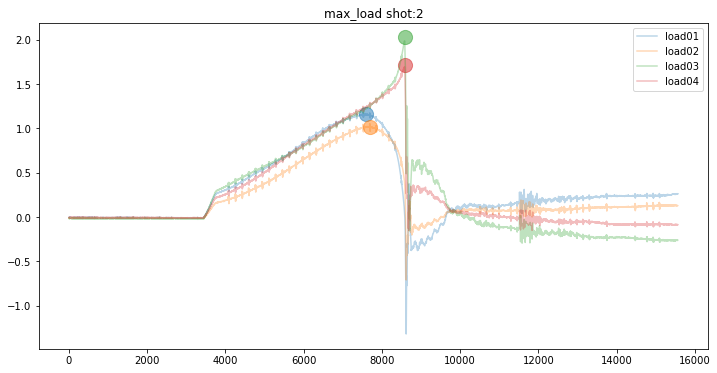

In [54]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
# load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start2, shot=shot_number, disp_chart=True)
#break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_varmax29, sub_func=narrowing_var_ch,shot=shot_number, disp_chart=True)

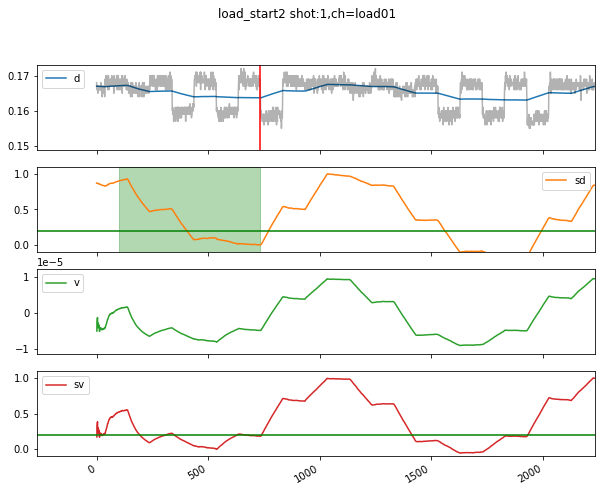

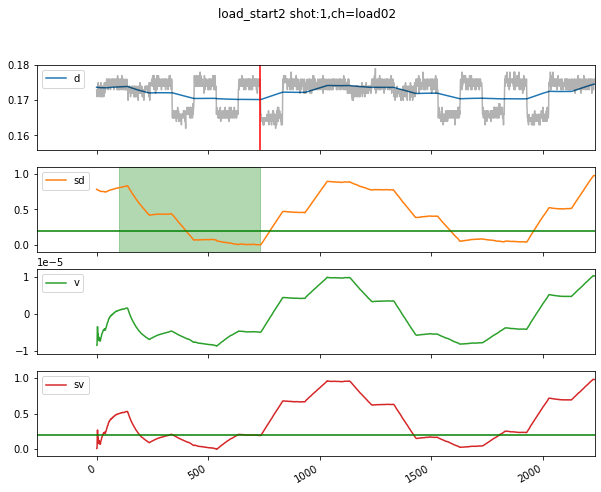

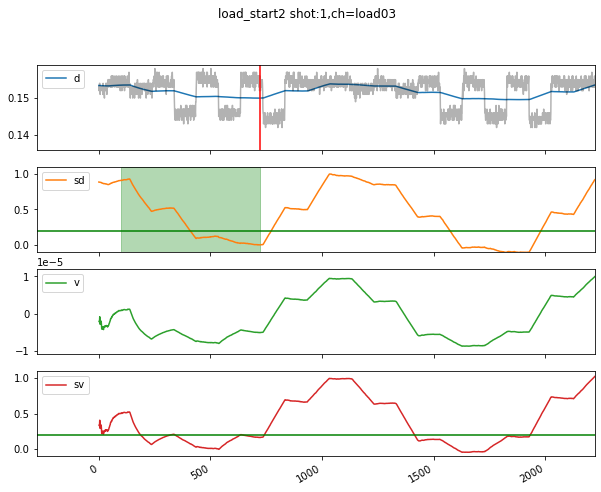

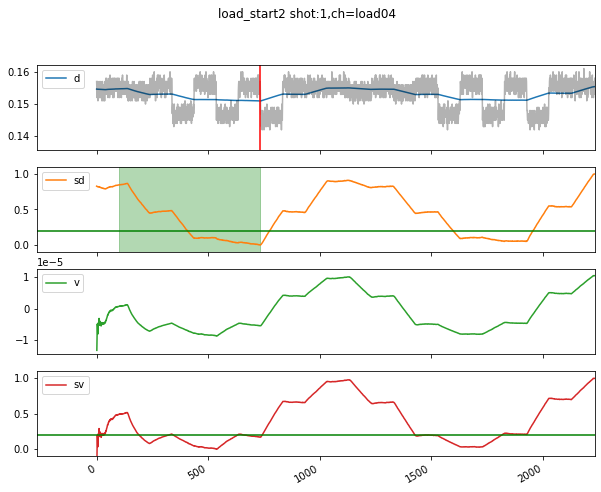

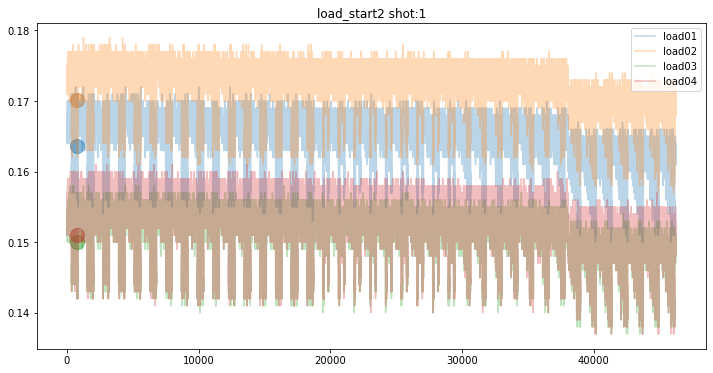

In [27]:
def load_start2(d, spm, r_window=399,Debug=False,shot=999,ch='loadxx',debug_xlim=[-1000,1500]):
    """ 荷重開始点 (速度変化版 rev.2)
    速度に加え荷重値も開始:最大荷重の範囲を標準化(初期0、最大荷重1に向けて徐々に上昇)し、
    標準化荷重の下限から0.2を超えるまでの範囲を検索範囲とする。これによって、SPMの考慮は必須ではなくなった。
    この検索範囲の中で標準化速度が0.2を初めて超えた点を荷重開始点とする。

    :d (np.array)        荷重系列データ
    :spm (float)         SPM(shots per minutes)、荷重開始→最大→破断の推移の速度にほぼ反比例すると考えられる。今のところ未使用>  。                                           囲
    :r_window (int)      移動平均ウィンドウ範囲
    :Debug (bool)        グラフ表示
    :return (int,float,*)  最大開始点index, 荷重開始値

    ToDo: 荷重開始前の水平区間は、全体の傾向としてやや下降していることが多く、
          荷重下限は荷重開始の直前に来ることが多い。この場合、アルゴリズムはうまく機能するが、
          稀に荷重下限がショット開始付近になることがあり(shot#441,442,541)、この場合に0.2の閾値が怪しくなる。
          検索範囲及び標準化範囲を、標準化荷重が0.2を超えた点から遡って固定長(この場合はspmの考慮必要)とすることで、
          アルゴリズムとしては、より良好に機能すると思われる。
          しかしながら、荷重開始前の水平区間のゆらぎが、鋼板のたわみのようなものだとすると、
          このような考慮はむしろ特定される荷重開始点のゆらぎに繋がるのではないか?
    """
    df = pd.DataFrame({'o':d})
    df['d'] = df.o.rolling(r_window,center=True,min_periods=1).mean()   # 移動平均
    df['v'] = df.d.diff().rolling(r_window,min_periods=1).mean()        # 速度

    argmax = df.d.idxmax()                                # 100:変位最大値位置の範囲で速度を標準化 -> df['s']
    l_max = df.d[argmax]
    l_min = df.d[100:argmax].min()
    df['sd'] = (df.d - l_min) / (l_max - l_min)           # 標準化変位
    l_max = df.v[0:argmax].max(); #print(l_max)
    l_min = df.v[100:argmax].min(); #print(l_min)   # これをできるだけ直前に持っていきたい
    df['sv'] = (df.v - l_min) / (l_max - l_min)

#     h = df[df.d.argmax()-1200:][df.sv>0.2].index[0]        # 最大点-1200の範囲で、標準化速度が0.2を超えた最初の点
    sd_start = df[100:df.d.idxmax()].sd.idxmin()           # 100:最大荷重の範囲の荷重最小点 -> sd_start
    sd_end = df[100:df.d.idxmax()][df.sd>0.2].index[0]     # 標準化変位が0.2を超えた -> sd_end
    if sd_start >= sd_end:
        h = sd_start
    else:
        h = df[sd_start:sd_end][df.sv>0.2].index[0]            # sd_start:sd_endの範囲で、標準化速度が0.2を超えた最初の点

    if Debug is True:
        ax = df[['d','sd','v','sv']].plot(figsize=(10,8),subplots=True,c='b',
                title='%s shot:%d,ch=%s'%(sys._getframe().f_code.co_name,shot,ch))
        df.o.plot(ax=ax[0],alpha=.3,c='black');
        ax[0].axvline(h,c='r')
        ax[1].set_ylim(-0.1,1.1); ax[1].axvspan(sd_start,sd_end,color='g',alpha=.3),ax[1].axhline(0.2,c='g')
        ax[3].set_ylim(-0.1,1.1); ax[3].axhline(0.2,c='g')
        plt.xlim(h+debug_xlim[0],h+debug_xlim[1])

    # 値として元波形 or ノイズ除去後のいずれを採用すべきかは個々に判断されるべきと考えるので、
    # indexと併せて(ノイズ除去後の)値も返す仕様とする。
    return h, df.d[h], sd_start


load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start2, shot=shot_number, disp_chart=True, Debug=True)

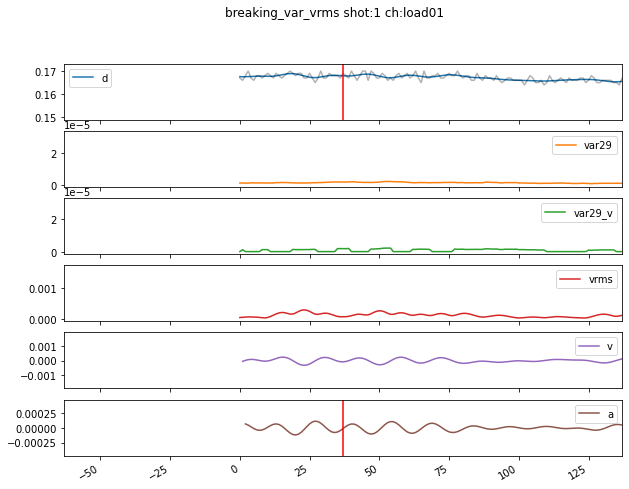

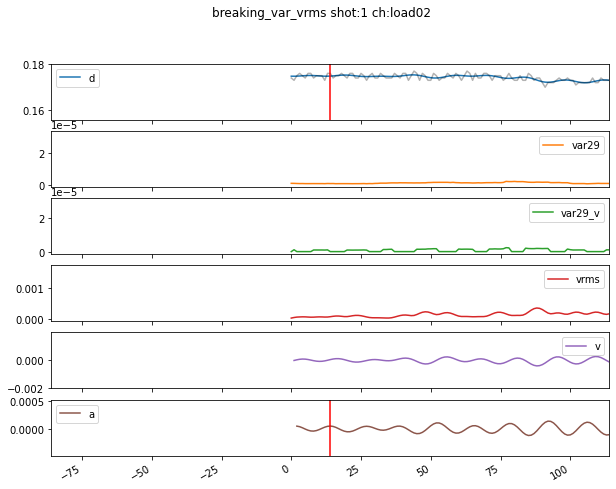

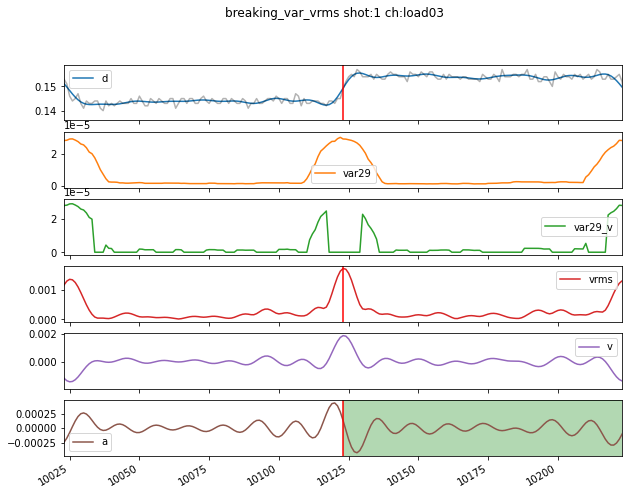

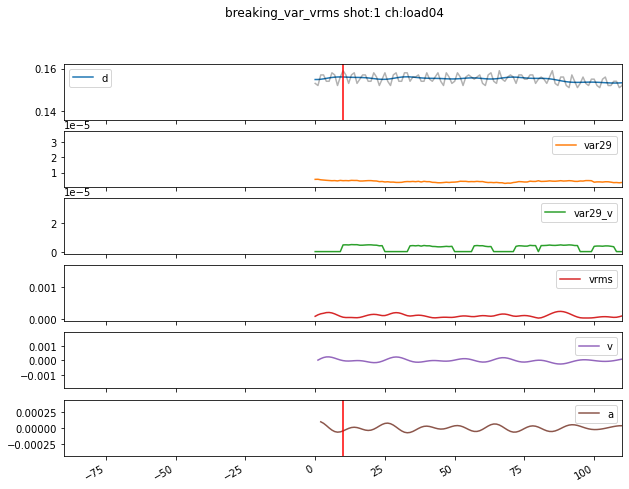

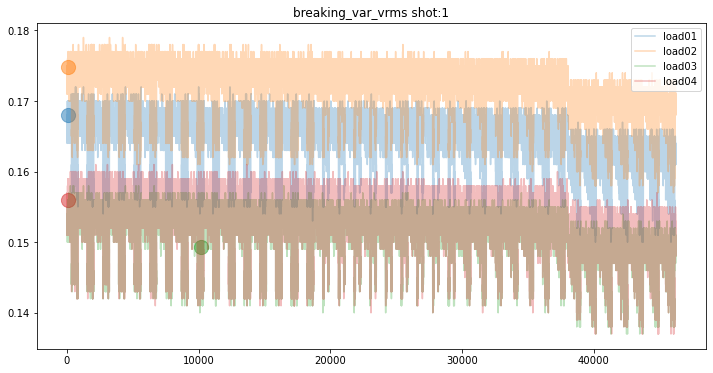

In [31]:
def narrowing_var_ch(shot_df,disp_narrowing = False,shot=9999):
    """ 検索範囲限定のためのヘルパー関数 (破断点専用)
    荷重4ch(load01,load02,load03,load04)を含むshot dataを受け取り、
    4ch間の分散を考慮することにより、最小限の検索範囲を返す。
    破断の前に、破断側/非破断側間の同期が崩れ、分散が増大することを利用している。

    :shot_df (pd.DataFrame)     shotデータを含むDataFrame
    :disp_narrowing (bool)      グラフ表示
    :shot (int)                 shot番号
    :return (int,int)           検索範囲の左端と右端のindex

    ToDo: 341(破断前のch間分散が極端に小さいケース; 破断/非破断の判別は辛うじてできている)
    """
    SVAR_CRITERIA = 0.2   # 0.3だと破断後になるケースあり(shot#425)
    df = shot_df.copy()
    df['var_raw'] = df[['load01','load02','load03','load04']].var(axis=1)
    df['var'] = df['var_raw'].rolling(49,min_periods=1,center=True).mean()
    l_max = df['var'].max()
    l_min = df['var'].min()
    df['svar'] = (df['var'] - l_min) / (l_max - l_min)
    df['bool'] = (df['svar']>SVAR_CRITERIA).astype(int)         # 0.1だと荷重開始点で反応するものが10件くらい
    upward_list = df[df['bool'].diff()==1].index   # diff()を取って、1になるのは上向きに跨いだポイント
    if len(upward_list) > 0:
        var_start = upward_list[0]
    else:
        var_start = df.index[0]    # 分散が.2以上にならないケース; 標準化してるのであり得ない
    downward_list = df[df['bool'].diff()==-1].index   # diff()を取って、-1になるのは下向きに跨いだポイント
    if len(downward_list) > 0:
        var_end = downward_list[0]                        # 0.2を超えた最初の山の範囲がvar_start:var_end,  var_endが広すぎるケースがほとんど
    else:
        var_end = np.min([df.index[-1],var_start+300])    # 分散が.2以下に降りてこないケース; これはあり得る。

    if var_start - NARROW_PADDING < 0 or var_end + NARROW_PADDING > df.index[-1] or var_end - var_start < 50:   # 限定幅が50未満になったら限定を無効にする。
        var_start = df.index[0]
        var_end = df.index[-1]

    if disp_narrowing == True:
        plt.figure(figsize=(12,6))
        ax1 = plt.subplot(311)
        df[['load01','load02','load03','load04']].plot(ax=ax1)
        ax2 = plt.subplot(312,sharex=ax1)
        df[['var_raw']].plot(ax=ax2)
        ax3 = plt.subplot(313,sharex=ax1)
        df[['svar']].plot(ax=ax3)
        ax3.axvspan(var_start,var_end,color='r',alpha=.2)
        ax3.axhline(SVAR_CRITERIA,color='g',alpha=.5)
        plt.xlim([var_start-1500,var_end+800]);
        plt.suptitle('variance on 4ch  shot:%d'%shot)
        plt.show()

    return var_start, var_end


def extract_features(shot_data, spm, func, narrowing = None, sub_func=None, disp_narrowing=False,disp_chart=False,xlim=[0,0],**kwargs):
    """ 特徴抽出ハンドラ関数
    変位をトリガーに切り出した1ショットのデータをpd.DataFrame(shot_data)として受け取り、
    抽出した特徴値を返す。
    shot_dataは4ch('load01','load02','load03','load04')固定であり、
    特徴値はindexと値をそれぞれ長さ4のリストとして返す。

    funcは特徴抽出関数のポインタであり、kwargsはfuncにそのまま渡される。
    kwargsの内容には基本的に感知しないが、例外が二つ。
    disp_chartが指定された場合は、kwargsの中にshotの存在を期待することと、
    funcを呼び出す際にkwargsにchを追加すること。
    extract_features()にとってのshot、funcにとってのchは、
    いずれも本質的には必要のない変数だが、デバッグ、処理状況の把握のため必要となる。

    disp_chartは、元波形と特徴量をプロットすることでfuncの処理結果を可視化する。
    さらに詳細な、処理過程を確認したい場合はDebugの指定によりchごとの可視化が行われる。
    extract_features()の利用者にとって意識し辛いと思われるが、
    disp_chartはextract_features()に対する引数であり、Debugはfuncに対する可変キーワード引数である。

    :shot_data (pd.DataFrame)
    :spm (float)                      SPM(shots per minutes)
    :func (*function)                 関数ポインタ; 求めたい特徴値により対応する関数を指定
    :sub_func (*function)             関数ポインタ; 処理効率改善のため時系列検索範囲を限定する必要があり、
                                      4ch共通の範囲を指定したい場合に使用。現在は破断点の場合のみ、narrowing_var_chを指定。
    :disp_narrowing (bool)            sub_funcで指定した関数に渡され、グラフ表示を制御する
    :disp_chart (bool)                グラフ表示; ショットごとの元波形と特徴量を表示。
    :**kwargs (可変キーワード引数)    funcに指定した関数に対応した引数を指定
    :return (list, list, list)        indexリスト, 値リスト, デバッグリスト
    """
#     print(shot_data.head())
    cmap = plt.get_cmap("tab10")
    if spm is None:                  # 最後のショットは次のショットが無いためspm計算不能, 80を想定する。
        spm = 80.0

    if 'shot' in kwargs:
        shot = kwargs['shot']             # 可変キーワード変数から拝借; 掟破り
    else:
        shot = 9999

    if narrowing is not None:
        sub_start = narrowing[0] - NARROW_PADDING
        sub_end = narrowing[1] + NARROW_PADDING
    else:
        if sub_func is not None:
            sub_start, sub_end = sub_func(shot_data,disp_narrowing,shot)
            # NARROW_PADDING考慮の上で限定範囲がデータの先頭/終端を超える場合、
            # また限定範囲が50より狭い場合は範囲限定を無効にする。
            if sub_start - NARROW_PADDING < 0 or sub_end + NARROW_PADDING > shot_data.index[-1] or sub_end - sub_start < 50:
                sub_start = shot_data.index[0]
                sub_end = shot_data.index[-1]
            else:
                sub_start = sub_start - NARROW_PADDING
                sub_end = sub_end + NARROW_PADDING
        else:
            sub_start = shot_data.index[0]
            sub_end = shot_data.index[-1]

    argmax = []; valmax = []; debugval = [];
    chs = ['load01','load02','load03','load04']
    for ch in chs:
        kwargs['ch'] = ch                                    # 可変キーワードにch追加
        i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
        argmax.append(i+sub_start)                  # funcはsubset中の相対indexを返してくるので、offsetを加える
        valmax.append(v)
        debugval.append(d)

    if disp_chart:
        plt.figure(figsize=(12,6))
        for c in range(len(chs)):
            plt.plot(shot_data.index,shot_data[chs[c]],label=chs[c],alpha=.3,c=cmap(c)) # 「流れ」があるのでscatterよりlineの方が見やすいと思う
            #plt.scatter(shot_data.index,shot_data[chs[c]],label=chs[c],s=2,alpha=1.0,c=[cmap(c)]*len(shot_data))
            plt.scatter([argmax[c]],[valmax[c]],marker='o',s=200,alpha=.5,c=[cmap(c)])  # plotとscatterのcolor mapを揃える
        plt.title('%s shot:%d'%(func.__name__,shot)); plt.legend();
        if xlim[0] != 0 or xlim[1] != 0:
            plt.xlim(np.array(argmax).min()+xlim[0],np.array(argmax).max()+xlim[1]);
        plt.show()

    return argmax,valmax,debugval



break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_var_vrms, sub_func=None ,shot=shot_number, disp_chart=True, Debug=True)

In [164]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[469, 2856, 469, 6433], values：[0.16956990957110368, 0.17669491146506106, 0.1561853512817649, 0.15729389253533374]
【荷重開始点】
 indicies：[1328, 1323, 1233, 1272], values：[0.3494862155388455, 0.32277192982456043, 0.2999373433583944, 0.326390977443609]
【破断点】　　
 indicies：[3034, 3034, 3037, 3037], values：[2.0029999999999957, 1.6629999999999996, -0.24399999999999902, 0.2110000000000013]


# 全ショットにロジック適用

## データ読み込み
指定したインデックスの全ショットデータを読み込みます。これには時間がかかります。  
時間目安：10,000,000件読み込みで約3分

In [143]:
# 対象指定
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [144]:
%%time
dr = DataReader()
shots_df = dr.read_all(shots_data_index)
len(shots_df)

2021-03-05 09:20:20,723 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-03-05 09:20:20,725 [INFO] データ件数: 17351
2021-03-05 09:20:20,924 [INFO] Data reading has finished.


CPU times: user 185 ms, sys: 14.5 ms, total: 199 ms
Wall time: 264 ms


17351

In [145]:
# ショットメタデータ読み込み
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [146]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=max_load,
    sub_func=None,
)

2021-03-05 09:20:25,786 [INFO] apply start.
2021-03-05 09:20:25,860 [INFO] delete index 'shots-20201202020000-max-point' finished. result: {'acknowledged': True}
2021-03-05 09:20:26,232 [INFO] apply finished.


In [147]:
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

2021-03-05 09:20:28,177 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-03-05 09:20:28,181 [INFO] データ件数: 16
2021-03-05 09:20:28,188 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load03,2815,2815,1.430821
1,1,load04,2818,2818,1.578990
2,1,load01,3018,3018,2.373269
3,1,load02,3018,3018,1.972137
4,2,load04,7189,2648,1.492697
5,2,load03,7234,2693,1.367463
6,2,load01,7438,2897,2.507801
7,2,load02,7439,2898,2.150089
8,3,load03,11454,2531,1.341172
9,3,load04,11464,2541,1.470283


In [148]:
# 荷重開始点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=load_start2,
    sub_func=None,
)

2021-03-05 09:20:34,346 [INFO] apply start.
2021-03-05 09:20:34,414 [INFO] delete index 'shots-20201202020000-start-point' finished. result: {'acknowledged': True}
2021-03-05 09:20:34,819 [INFO] apply finished.


In [150]:
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

2021-03-05 09:20:40,185 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-03-05 09:20:40,189 [INFO] データ件数: 16
2021-03-05 09:20:40,194 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load03,1233,1233,0.299937
1,1,load04,1272,1272,0.326391
2,1,load02,1323,1323,0.322772
3,1,load01,1328,1328,0.349486
4,2,load03,5479,938,0.225521
5,2,load01,5777,1236,0.324900
6,2,load04,5791,1250,0.307559
7,2,load02,5860,1319,0.320496
8,3,load03,10067,1144,0.207439
9,3,load01,10104,1181,0.243461


In [151]:
# 破断点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=breaking_var_vrms,
    sub_func=narrowing_var_ch,
)

2021-03-05 09:20:41,852 [INFO] apply start.
2021-03-05 09:20:41,919 [INFO] delete index 'shots-20201202020000-break-point' finished. result: {'acknowledged': True}
2021-03-05 09:20:42,577 [INFO] apply finished.


In [152]:
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

2021-03-05 09:20:43,700 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-03-05 09:20:43,704 [INFO] データ件数: 16
2021-03-05 09:20:43,708 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value,break_channels
0,1,load01,2927,2927,1.875522,"[load03, load04]"
1,1,load02,2927,2927,1.619204,"[load03, load04]"
2,1,load04,2928,2928,1.353978,"[load03, load04]"
3,1,load03,2929,2929,1.103029,"[load03, load04]"
4,2,load01,7343,2802,1.986433,"[load03, load04]"
5,2,load02,7343,2802,1.694278,"[load03, load04]"
6,2,load03,7344,2803,1.024387,"[load03, load04]"
7,2,load04,7344,2803,1.293347,"[load03, load04]"
8,3,load01,11627,2704,1.980850,"[load03, load04]"
9,3,load02,11627,2704,1.674132,"[load03, load04]"
